# Seminario de Ciencia de Datos

## 2º Cuatrimestre de 2017

## Módulo 6 - Procesamiento del Lenguaje Natural

### Integrantes:

- Mascitti, Julio Augusto - 954/11 - mascittija@gmail.com

- Aleman, Damián - 377/10 - damianaleman@gmail.com

- Guerson, Matias Carlos - 925/10 - matias.guerson@gmail.com

In [208]:
import os
import xml.etree.ElementTree
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.tokenize import wordpunct_tokenize
import string
import numpy as np
import matplotlib.pyplot as plt
import math
import functools
import random
import operator as op
import re
from gensim import models, corpora
import scipy as sp
#nltk.download()

## Asociación de palabras

### 1) Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccioinario

In [166]:
# Se escapearon los & en el archivo y se agregaron los tags <DOCS> para poder parsearlo como un xml
inputXML = './data/ap/ap.txt'
e = xml.etree.ElementTree.parse(inputXML).getroot()
docs = {}

for elem in e.getchildren():
    text = elem.find('TEXT').text
    docno = elem.find('DOCNO').text.strip()
    docs[docno] = text

#docs

In [165]:
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [183]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') +  list(string.punctuation)
vocabulary = {}
bigrams_map = {}
docs_words = {}

for docno, text in docs.items():
    docs_words[docno] = []
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        tokens = nltk.word_tokenize(sentence)
        
        for bigram in bigrams(tokens):
            if (bigram[0] not in stop_words) and (bigram[1] not in stop_words):
                bigrams_map.setdefault((bigram[0], bigram[1]), 0)
                bigrams_map.setdefault((bigram[1], bigram[0]), 0)
                bigrams_map[bigram[0],bigram[1]] = bigrams_map[bigram[0],bigram[1]] + 1
                bigrams_map[bigram[1],bigram[0]] = bigrams_map[bigram[1],bigram[0]] + 1
        tags = nltk.pos_tag(tokens)
        for word, tag in tags:
            wornet_pos = get_wordnet_pos(tag)
            if wornet_pos:
                lemma = lemmatizer.lemmatize(word, wornet_pos)
            else:
                lemma = lemmatizer.lemmatize(word)
            if lemma not in stop_words:
                vocabulary.setdefault(lemma, 0)
                vocabulary[lemma] = vocabulary[lemma] + 1
                docs_words[docno].append(lemma.upper())


### 2) Calcular el tamaño del vocabulario

In [23]:
print("El tamaño del vocabulario es", len(vocabulary))

El tamaño del vocabulario es 41169


### 3) Para las 500 palabras con más apareiciones, calcular el par más asociado según la medida presentada

In [24]:
first_500 = list(map(lambda x: x[0], sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)[:500]))
ordered_bigrams = sorted(bigrams_map.items(), key=lambda x: x[1], reverse=True)

for word in first_500:
    for bigram_entry in ordered_bigrams:
        if bigram_entry[0][0] == word:
            print(word, ",", bigram_entry[0][1])
            break


say , officials
`` , I
'' , said
's , It
The , ``
year , last
would , n't
I , ``
percent , 20
He , said
million , shares
n't , ca
people , million
one , said
also , said
government , 's
make , sure
It , ``
U.S. , District
In , ``
two , years
official , said
report , said
last , year
go , would
take , place
But , ``
A , ``
time , first
state , 's
could , n't
Bush , 's
We , ``
include , would
new , The
get , n't
day , one
first , time
tell , n't
Soviet , Union
week , last
New , York
United , States
company , 's
use , drug
call , 's
billion , 1
work , n't
month , last
country , 's
give , would
come , n't
today , said
plan , 's
president , vice
police , said
Thursday , said
American , people
three , years
group , The
States , United
since , time
Tuesday , said
market , stock
member , states
price , bid
President , Bush
issue , The
Monday , said
Friday , said
high , school
force , task
Wednesday , said
They , ``
know , n't
think , I
want , n't
find , n't
begin , would
charge , possession
le

## Informació Léxica

### 1) Procesar el texto, tokenizando eliminando signos de puntuación

In [139]:
punctuation = list(string.punctuation)
tokens = []
with open('./data/on-the-origin-of-species.txt') as file:  
    data = file.read() 
    tokens = list(filter(lambda x: x not in punctuation, nltk.word_tokenize(data)))
    #tokens2 = list(nltk.word_tokenize(data))
    
print(len(tokens))
#print(len(tokens2))

209609


### 2) Siguiendo el articulo de la sección, calcular la autocorrelacion para estimar la distribución de la palabra a lo largo del texto

In [11]:
words = ['plants', 'instinct', 'for']

def generate_apparitions_vector(word,tokens):
    return [i for i, x in enumerate(tokens) if x == word]

std = 50
std_square = std ** 2
twice_std_square = 2 * std_square
denominator = np.sqrt(2 * np.pi) * std

def gaussian(x):
    x_square = x ** 2 
    exp = (-1) * (x_square / twice_std_square) 
    numerator = np.e ** exp
    return numerator / denominator

text_size = len(tokens)
gaussians = {}
for i in range(text_size):
    gaussians[i] = gaussian(i)
    gaussians[-i] = gaussian(-i)
    
def ro_w(t, apparitions):
    sum = 0
    for i in apparitions:
        sum += gaussians[t - i]
    return sum

def plot_apparitions_from(word, ro_vector):
    a = [ro_vector[i] for i in range(text_size)]
    plt.plot(a)
    plt.title('Apariciones de ' + word)
    plt.xlabel('Posición del texto')
    plt.ylabel('Rate')
    plt.show()
    
    
def calcular_autocorrelacion(tau,ro_vector):
    tamanio = text_size - tau

    acum_ro_i = 0
    acum_ro_it = 0
    acum_ro_i_it = 0
    acum_ro_i_2 = 0
    
    for i in range(tamanio):
        ro_i = ro_vector[i]
        ro_it = ro_vector[i+tau]

        acum_ro_i += ro_i
        acum_ro_it += ro_it
        acum_ro_i_it += ro_i * ro_it

        acum_ro_i_2 += ro_i ** 2

    prom_ro_i_it = acum_ro_i_it / tamanio
    prom_ro_i = acum_ro_i / tamanio
    prom_ro_it = acum_ro_it / tamanio
    prom_ro_i_2 = acum_ro_i_2 / tamanio
    square_prom_ro_i = prom_ro_i ** 2
    
    autocorrelacion = (prom_ro_i_it - (prom_ro_i * prom_ro_it)) / (prom_ro_i_2 - square_prom_ro_i)
    return autocorrelacion

def plot_autocorrelation_from(word, ro_vector):
    rangos = np.arange(0, 10000, 50) #[10, 50, 100, 250, 500, 750, 1000]

    a = [calcular_autocorrelacion(tao,ro_vector) for tao in rangos]
    plt.plot(a)
    plt.title('Autocorrelación de ' + word)
    plt.xlabel('Posición del texto')
    plt.ylabel('Autocorrelación')
    plt.show()
    
    
def calculate_ro_vector(apparitions):
    ro_vector = [ro_w(i, apparitions) for i in range(text_size)]
    return ro_vector


def graficos(words,tokens):
    for word in words:
        apparitions = generate_apparitions_vector(word,tokens)

        ro_vector = calculate_ro_vector(apparitions)
        
        plot_apparitions_from(word, ro_vector)
        plot_autocorrelation_from(word, ro_vector)

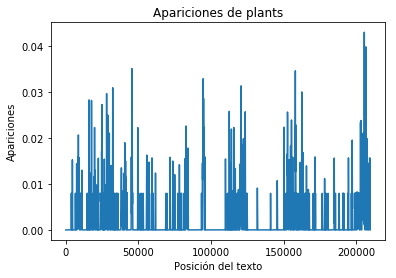

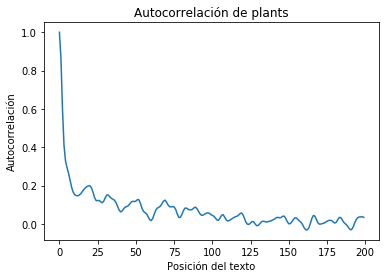

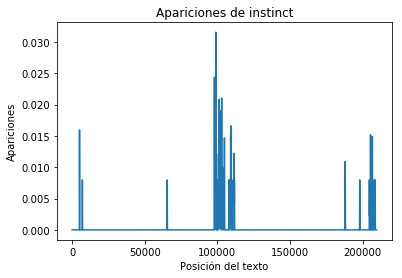

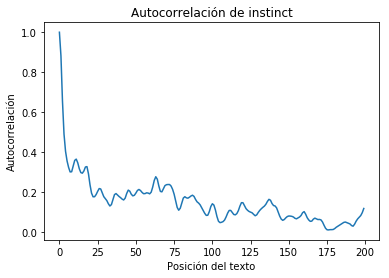

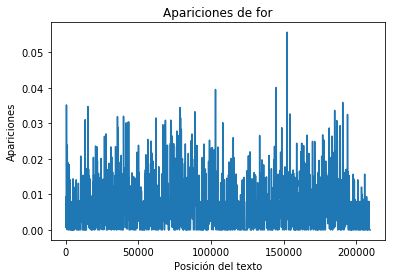

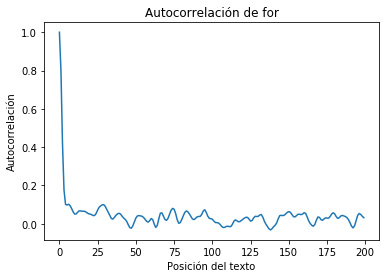

In [12]:
graficos(words,tokens)

### 3) Calcular la entropía de una selección de 100 palabras que abarquen el rango de frecuencia de aparición en el libro, es decir, elegir palabras que son muy frecuentes y otras de baja frecuencia

In [92]:
def calcular_particiones(apparitions,i,cota):
    return len(list(filter(lambda x: i*cota <= x < (i+1)*cota, apparitions)))

def H(apparitions, P, longitud_P, n):
    ocurrencias = [calcular_particiones(apparitions, i, longitud_P) for i in range(P)] 
    acum = 0
    for i in range(P):
        calculo = ocurrencias[i] / n
        if calculo != 0:
            acum += calculo * math.log2(calculo)
    
    return - acum

def entropy(word,tokens):
    apparitions = generate_apparitions_vector(word,tokens)

    N = text_size
    P = 64
    longitud_P = N // P
    
    n = len(apparitions)

    return n, H(apparitions, P, longitud_P, n)
    
def entropy_plot(palabras, tokens):
    a = [entropy(w, tokens) for w in palabras]
    plt.scatter([x[0] for x in a], [x[1] for x in a], s=3)
    plt.xscale("log", nonposx='clip')
    plt.show()


In [14]:
app_dicc = {}

for w in set(tokens):
    app_dicc[w] = len(generate_apparitions_vector(w,tokens))
    
apariciones = sorted(app_dicc.items(), key=lambda x:x[1])




In [222]:
# Tomamos las 100 palabras de manera tal que representen el rango completo de fecuencias de palabras
# desde la de menor cantidad de aparicione, hasta la mayor, pasando por todos los valores intermedios
palabras = [apariciones[i][0] for i in np.arange(0, len(apariciones), len(apariciones)//100)]

In [16]:
palabras2 = [p[0] for p in apariciones[-2000:]]

In [223]:
entropy_plot(palabras,tokens)
#entropy_plot(palabras2,tokens)

ZeroDivisionError: division by zero

### 4) Calcular la entropíade las palabras seleccionadas anteriormente, randomizando su posición en el texto. Compara los resultados con el punto anterior

In [140]:
random_tokens = list(tokens)
random.shuffle(random_tokens)
random.shuffle(random_tokens)
random.shuffle(random_tokens)
random.shuffle(random_tokens)
random.shuffle(random_tokens)

entropy_plot(palabras,random_tokens)
entropy_plot(palabras2,random_tokens)

In [144]:
a = [entropy(w, tokens) for w in palabras2]
b = [entropy(w, random_tokens) for w in palabras2]

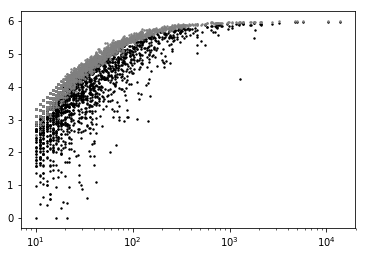

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter([x[0] for x in a], [x[1] for x in a], s=2, color='black')
ax.scatter([x[0] for x in b], [x[1] for x in b], s=2, color='grey')
ax.set_xscale("log", nonposx='clip')
plt.show()

### Información mutua

#### Información mutua de las 100 palabras seleccionadas

In [77]:
def mutual_information(word,tokens):
    apparitions = generate_apparitions_vector(word,tokens)
    
    N = text_size
    P = 64
    longitud_P = N // P
    n = len(apparitions)

    p_w = n / N

    h_w = H(apparitions, P, longitud_P, n)
    
    H_w_mean = H_mean_w(n, N, P)
    
    return p_w * (H_w_mean - h_w)


def H_mean_w(n, N, P):
    cota = int(min(n,N/P))
    return (-P) * sum(map(lambda m: internal_function(m, n, N, P), [m for m in range(1,cota+1)]))
    
def internal_function(m, n, N, P):
    aux = (m/n) * np.log2(m/n) * marginal_probability(m, n, N, P) 
    return aux
    

def marginal_probability(m, n, N, P):
    a = nCr(n,m)
    b = nCr((N-n), (N/P)-m)
    c = comb_N_NdivP
    return a * b / c


def nCr(n, r):
    n = int(n)
    r = int(r)
    #print(n, r, min(r, n-r))
    r = min(r, n-r)
    if r == 0: return 1
    #numer = functools.reduce(op.mul, np.arange(n, n-r, -1))
    numer = functools.reduce(op.mul, range(n-r, n, 1))
    denom = functools.reduce(op.mul, range(1, r+1))
    return numer//denom

In [ ]:
sum(map(lambda w: mutual_information(w,tokens), palabras))

## Word embeddings, distancia semantica y WordNet

### 1) Utilizando el test WordSim353, comparar el rendimiento de LSA y Word2Vec 

##### WORDSIM 353

In [189]:
wordsim_words_file = './data/wordsim353_sim_rel/wordsim353_annotator1.txt'
ignored_lines = 11

with open(wordsim_words_file) as file:  
    data = file.readlines()

wordsim_classifications = {}
data = data[11:]
for line in data:
    splitted_line = re.split(r'\t', line[:-1])
    wordsim_classifications[(splitted_line[1].upper(), splitted_line[2].upper())] = float(splitted_line[3]) / 10
    
#wordsim_classifications

##### WORD2VEC

In [200]:
modelWord2Vec = word2vec.Word2Vec(docs_words.values(), size=100, window=5, min_count=5, workers=4)
#model.wv.similarity('ADMISSION', 'TICKET')

##### LSI

In [215]:
words = corpora.Dictionary(docs_words.values())
corpus = [words.doc2bow(text) for text in docs_words.values()]
lsiModel = models.LsiModel(corpus, id2word=words, num_topics=4)

In [220]:
for text in docs_words.values():
    vec_bow = words.doc2bow(text)
    #print(lsiModel[vec_bow])
    
lsiModel.

2250

#### COMPARACIONES

In [205]:
word2vec_classifications = {}
classifications = np.zeros((len(wordsim_classifications), 3))

for i, (pair, wordsim_classification) in enumerate(wordsim_classifications.items()):
    try:
        word2vec_classification = modelWord2Vec.similarity(pair[0], pair[1])
    except:
        word2vec_classification = 0.0
        
    word2vec_classifications[pair] = word2vec_classification
    classifications[i, 0] = wordsim_classification
    classifications[i, 1] = word2vec_classification

classifications

array([[ 0.677     ,  0.90411616,  0.        ],
       [ 0.735     ,  0.96308877,  0.        ],
       [ 1.        ,  1.        ,  0.        ],
       ..., 
       [ 0.625     ,  0.73134676,  0.        ],
       [ 0.634     ,  0.78874056,  0.        ],
       [ 0.378     ,  0.94861295,  0.        ]])

In [206]:
sp.spatial.distance.euclidean(classifications[:, 0], classifications[:, 1])

8.18533282088668

### 2) Compara los distintos word embeddings con las medidas definids en WordNet